In [9]:
import glob
import os
import numpy as np
import pandas as pd
import series_utils
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from hmmlearn import hmm
import hmm_helper
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import confusion_matrix
import itertools

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
dirpath = '/home/jarvis/Documentos/catalina/hmm/TIME_SERIES/'
subjects = [os.path.basename(x) for x in glob.glob(dirpath + '*sub*')]
scans = ['_scan_restpre', '_scan_restpost']
stimuli = ['ses-occ','ses-ctr', 'ses-fro' ]

parcel="_mask_Schaefer2018_400_17N_MNI152_2mm_mask_file_..input..data..Schaefer2018_400_17N_MNI152_2mm.nii.gz"
np.random.seed(42)

In [12]:
schafer_file = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_Centroid_RAS.csv'
schafer = pd.read_csv(schafer_file, header=None, skiprows=[0,1])
schafer['network'] = schafer[1].str.split('_').str.get(2)
schafer['network_id'] = schafer.network.astype("category").cat.codes
schafer_image = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_MNI152_2mm.nii'

In [13]:
def get_time_series(dirpath, subjects, stimulus, scan, parcel,schafer):    

    subject_list = []
    all_data = []
    for subject in subjects:
        file_path = f'{dirpath}/{subject}/{stimulus}/roi_timeseries_0/{scan}/_compcor_ncomponents_5_selector_pc10.linear1.wm1.global0.motion1.quadratic1.gm0.compcor1.csf1/_bandpass_freqs_0.01.0.1/{parcel}/roi_stats.csv'
        series = pd.read_csv(file_path, skiprows=[0,1], header=None, delimiter='\t')
        series = series.T
        series['network'] = schafer['network']
        series_nolimbic = series[series.network!='Limbic']
        del series_nolimbic["network"]
        df_series = series_nolimbic.T
        all_data.append(df_series.values)
        subject_list.append(subject)
  
    return all_data, subject_list
    

def get_all_data(scans, stimuli,subjects, dirpath, parcel,schafer): 
    all_c = []
    all_subjects = []

    for scan in scans:

        for stimulus in stimuli:
  
            all_data, subject_list = get_time_series(dirpath, subjects, stimulus, scan, parcel,schafer)
            all_subjects = all_subjects +  subject_list
            all_c = all_c + all_data
          
    return all_c, all_subjects

In [14]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Matriz de confusión', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

#    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#    cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
#    cbar.ax.set_yticklabels(['< -1', '0', '> 1']) 
    cbar = plt.colorbar(ticks=[-1, 1])
    cbar.ax.set_yticklabels([cm.min(), cm.max()]) 
#    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Valores Reales')
    plt.xlabel('Valores Predicción')

In [15]:
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, label='Curva ROC (area = %.2f)' %auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance')
    plt.title('curva ROC')
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderros positivos')
    plt.grid()
    plt.legend()
    plt.show()

# Average pre

In [16]:
occ_pre, subjects_list_occ_pre = get_all_data(['_scan_restpre'], ['ses-occ'], subjects, dirpath, parcel,schafer)
fro_pre, subjects_list_fro_pre = get_all_data(['_scan_restpre'], ['ses-fro'], subjects, dirpath, parcel,schafer)


pre_average = list((np.array(fro_pre) + np.array(occ_pre))/2)

## OCC

In [17]:
occ_post, subjects_list_occ_post =  get_all_data(['_scan_restpost'], ['ses-occ'], subjects, dirpath, parcel,schafer)

In [18]:
all_occ = pre_average + occ_post
subjects_occ = subjects_list_occ_pre + subjects_list_occ_post
y_occ = [0]*len(subjects_list_occ_pre) + [1]*len(subjects_list_occ_post)

In [19]:
cat_subjects = pd.get_dummies(subjects_occ)

subjects_id_occ = cat_subjects.values.argmax(1)

class_names = ['Pre', 'Post']

In [20]:
X_occ = np.swapaxes(np.swapaxes(np.dstack(all_occ), 0,2),1,2)
y_occ = np.array(y_occ)

X_occ.shape

(46, 600, 376)

In [13]:
base_model = hmm.GMMHMM(covariance_type="diag",init_params="cm", params="cm")
model_hmm = hmm_helper.HMM_classifier(base_model)


pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D()),("model", model_hmm)])

parameters = {  'pca__n_components': [0.70, 0.8 ,0.85,0.9, 0.95, 1],
                'model__hmm_model': [base_model],
                'model__n_components':[*range(8,17)],
                'model__n_mix': [*range(2,10)]
}


In [14]:
grid_search_m_occ = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy", verbose = 3,n_jobs=-1)

grid_search_m_occ.fit(X = X_occ, y = y_occ, groups = subjects_id_occ)

Fitting 23 folds for each of 432 candidates, totalling 9936 fits
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  18.1s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  23.0s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  26.6s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  32.2s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=0.500 total time=  49.7s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, p

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.2min[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  16.9s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  20.6s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  20.7s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  24.6s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  31.3s
[CV 11/23] 

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.2min[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  17.1s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  22.8s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  27.7s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  39.6s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=1.000 total time=  51.3s
[CV 5/23] END

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  11.2s[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  18.0s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  22.6s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  26.9s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  30.8s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  38.2s
[CV 20/23] END

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.95;, score=0.500 total time= 1.1min[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  17.4s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  22.8s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  26.5s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  37.5s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=1.000 total time=  49.2s
[CV 3/23] EN

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  12.3s[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  17.5s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  20.8s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  27.6s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  34.2s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=1.000 total time=  53.5s
[CV 4/23] END mo

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  10.9s[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  17.2s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  20.5s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  24.6s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  23.4s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  32.0s
[CV 15/23] E

[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=0.500 total time=  19.0s[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  15.4s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  16.3s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  20.9s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  26.0s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  34.5s
[CV 10/23] E

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=0.500 total time=  19.4s[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  15.9s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  18.3s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  21.3s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  29.1s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  33.3s
[CV 13/23] EN

[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  20.0s[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  17.6s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  22.5s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  28.1s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  36.7s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=0.500 total time=  46.4s
[CV 2/23] 

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=0.500 total time=  28.1s[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  16.9s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  21.7s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  23.4s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  27.2s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  35.9s
[CV 17/23] E

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  25.6s[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  16.5s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  20.2s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  21.5s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  25.6s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  33.8s
[CV 14/23] E

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=0.500 total time=  31.5s[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  18.0s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  20.4s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  25.3s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  32.7s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  35.8s
[CV 19/23] E

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  34.6s[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  18.5s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  22.7s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  25.6s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  33.3s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=0.500 total time=  48.1s
[CV 23/23]

[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  42.5s[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  17.3s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  21.2s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  27.6s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  30.3s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  36.3s
[CV 18/23] END 

[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=0.500 total time=  47.9s[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  16.6s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  22.1s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  28.7s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  36.2s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=0.500 total time=  44.6s
[CV 22/23] END

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  51.7s[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  15.1s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  17.6s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  19.1s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  22.0s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  33.8s
[CV 9/23] 

[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  54.2s[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  16.6s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  22.4s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  24.8s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  35.3s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.95;, score=1.000 total time=  48.6s
[CV 21/23] EN

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  48.4s[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  17.1s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  21.6s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  24.1s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  26.8s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  32.4s
[CV 16/23]

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=0.500 total time= 1.2min
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.95;, score=0.500 total time= 1.1min
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  12.4s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  19.8s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  19.7s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=0.500 total time=  28.7s
[CV 16/23] E

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=0.8;, score=0.500 total time=  21.4s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  10.6s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=0.500 total time=  20.5s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  18.6s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  27.3s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  37.6s
[CV 14/23] EN

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=0.8;, score=0.500 total time=  19.4s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.1min
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  24.3s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  34.5s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  46.3s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=1.000 total time= 1.2min
[CV 1/23]

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=1;, score=0.500 total time=   8.4s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  11.2s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  12.8s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  21.1s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  28.4s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  36.0s
[CV 6/23] END mode

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=1;, score=0.500 total time=   8.8s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  18.3s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  28.1s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  37.4s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=0.500 total time=  45.4s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=1.000 total time= 1.3min
[CV 6/23] E

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.7;, score=0.500 total time=  15.4s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  51.8s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=1.000 total time= 1.2min
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  14.6s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  15.8s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  15.7s
[CV 5/23]

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  14.1s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  18.7s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=0.500 total time=  22.8s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  27.4s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  32.3s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  52.5s
[CV 13/23]

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  14.5s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=0.500 total time= 1.2min
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=0.500 total time=  13.7s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=0.500 total time=  12.6s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  14.7s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  19.2s
[CV 3/23] END mo

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.8;, score=0.500 total time=  20.7s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=0.500 total time=  21.3s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  20.8s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  27.8s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  36.0s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=0.500 total time=  48.9s
[CV 9/23] E

[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.85;, score=0.500 total time=  28.9s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  28.2s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=0.500 total time=  31.7s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  50.1s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=1.000 total time= 1.1min
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=0.500 total time= 1.2min
[CV 19/23] 

[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time=  54.5s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  36.0s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=0.500 total time=  48.6s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=0.500 total time= 1.2min
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=0.500 total time=  11.8s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  15.2s
[CV 18/23] E

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time= 1.1min
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  43.0s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=0.500 total time= 1.1min
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=0.500 total time=  14.1s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=1.000 total time=  12.5s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  15.2s
[CV 3/23] END mo

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time= 1.1min
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  11.6s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  17.9s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=0.500 total time=  28.5s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  36.2s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=0.500 total time=  47.0s
[CV 22/23] END 

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.2min
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  37.5s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  40.4s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=1.000 total time= 1.1min
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=0.500 total time=  12.5s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  15.1s
[CV 22/23]

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=0.500 total time=   8.6s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=0.500 total time=  11.7s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=0.500 total time=   9.1s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=0.500 total time=  11.8s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  13.4s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  15.8s
[CV 4/23] END model__

[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.0min
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=0.500 total time= 1.1min
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=1;, score=0.500 total time=  13.0s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  13.1s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  15.9s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  18.6s
[CV 2/23] E

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time=  56.3s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=0.500 total time= 1.2min
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=0.500 total time= 1.1min
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  14.7s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  16.9s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  21.1s
[CV 4/23

[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=0.500 total time=  16.0s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=0.500 total time=  32.9s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=0.500 total time=  49.5s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  47.0s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=1.000 total time= 1.3min
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.7s
[CV 21/23] E

[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time=  58.1s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  18.1s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  26.8s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.85;, score=0.500 total time=  31.3s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.9;, score=0.500 total time=  51.1s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=1.000 total time= 1.2min
[CV 2/23]

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  22.8s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=8, model__n_mix=9, pca__n_components=0.95;, score=1.000 total time= 1.2min
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   9.3s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  14.9s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  15.6s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  17.6s
[CV 22/23] 

[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.95;, score=1.000 total time= 1.1min
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=0.85;, score=1.000 total time=  27.0s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=0.9;, score=0.500 total time=  37.2s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time= 1.1min
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=1;, score=0.500 total time=   9.4s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=1;, score=0.500 total time=   9.2s
[CV 7/23] END m

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=5, pca__n_components=1;, score=0.500 total time=   8.6s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=0.85;, score=0.500 total time=  27.8s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=0.9;, score=0.500 total time=  40.3s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time=  58.0s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=0.95;, score=0.500 total time=  51.6s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  22.0s
[CV 11/23] E

[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.1s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.7;, score=0.500 total time=  13.8s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  14.9s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.8;, score=0.500 total time=  22.2s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  29.8s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=0.500 total time= 1.1min
[CV 5/23] 

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=6, pca__n_components=1;, score=0.500 total time=   9.3s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=7, pca__n_components=1;, score=0.500 total time=   8.8s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  15.0s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.8;, score=0.500 total time=  21.9s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  21.9s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  30.8s
[CV 17/23] END

[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  14.1s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  21.2s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  30.2s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time= 1.1min
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=0.500 total time= 1.3min
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=0.500 total time=   8.6s
[CV 17/23]

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  15.9s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  22.4s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  30.9s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=0.500 total time= 1.1min
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=0.500 total time= 1.3min
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=0.500 total time=   8.4s
[CV 15/23]

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.85;, score=0.500 total time=  28.9s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.5min
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time=  57.0s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=0.500 total time=  23.8s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  32.0s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  47.0s
[CV 10/

[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.85;, score=0.500 total time=  32.1s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  20.9s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  29.4s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time= 1.1min
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.2min
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=0.500 total time=   7.9s
[CV 20/23]

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.85;, score=1.000 total time=  28.8s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  37.5s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time=  59.2s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.2min
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=0.500 total time=   9.3s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  15.6s
[CV 9/23

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.9;, score=0.500 total time=  39.4s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=0.500 total time=  14.9s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=0.500 total time=  23.1s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  27.6s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  45.3s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.95;, score=1.000 total time= 1.1min
[CV 1/23]

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time=  43.6s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=0.500 total time=  22.7s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  23.9s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  33.2s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.9;, score=0.500 total time=  46.2s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.95;, score=0.500 total time= 1.1min
[CV 18/2

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=0.500 total time=   9.2s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  23.7s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  30.2s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.9;, score=0.500 total time=  45.7s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.95;, score=1.000 total time= 1.1min
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=1;, score=0.500 total time=   8.4s
[CV 17/23] END

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time=  59.0s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.8;, score=0.500 total time=  19.6s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  22.1s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  28.9s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time= 1.1min
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.3min
[CV 11/

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=0.500 total time=   9.1s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  31.4s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.9;, score=0.500 total time=  45.1s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.95;, score=0.500 total time= 1.1min
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=1;, score=0.500 total time=   9.8s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=1;, score=0.500 total time=   8.4s
[CV 19/23] END mode

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=0.500 total time=  15.7s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.3min
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=0.500 total time=   9.6s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=1.000 total time=  10.2s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=0.500 total time=  15.8s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  22.2s
[CV 2/23] END mo

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=0.500 total time=  15.2s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.3min
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=0.500 total time=   9.5s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=0.500 total time=   6.4s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=0.500 total time=   8.8s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=0.500 total time=  15.9s
[CV 6/23] END mod

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  23.8s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=0.500 total time=   8.5s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=0.500 total time=  14.2s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  15.3s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  23.3s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  32.0s
[CV 13/23] 

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=0.500 total time=  28.7s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=0.500 total time=  15.3s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  15.9s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  23.9s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=0.500 total time=  30.5s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.9;, score=1.000 total time=  47.6s
[CV 11/23

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  32.8s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=8, pca__n_components=1;, score=0.500 total time=   9.1s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  15.6s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.8;, score=0.500 total time=  22.3s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  30.7s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=9, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  31.9s
[CV 18/23] 

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.9;, score=0.500 total time=  42.9s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  12.9s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  15.3s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  19.4s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  23.9s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=2, pca__n_components=0.95;, score=0.500 total time=  32.7s
[CV 22

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  29.9s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=5, pca__n_components=1;, score=0.500 total time=   9.3s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  14.3s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  21.7s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=6, pca__n_components=0.85;, score=1.000 total time=  26.3s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  37.0s
[CV 1/23]

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  34.0s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=6, pca__n_components=0.85;, score=0.500 total time=  26.9s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  37.3s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  40.4s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=6, pca__n_components=0.95;, score=1.000 total time=  54.3s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.7;, score=0.500 total time=  14.0s
[CV 

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  19.5s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.8;, score=0.500 total time=  22.3s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.85;, score=1.000 total time=  28.6s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.9;, score=0.500 total time=  42.6s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time= 1.0min
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=0.500 total time=  11.2s
[CV 14/23

[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  20.8s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.7;, score=0.500 total time=  15.6s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  14.8s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.8;, score=1.000 total time=  20.4s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.85;, score=0.500 total time=  31.0s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.9;, score=0.500 total time=  38.9s
[CV 3/

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time= 1.3min
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=0.500 total time=   9.5s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=0.500 total time=  17.8s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  21.3s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  23.9s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  30.4s
[CV 16

[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.85;, score=1.000 total time=  48.3s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.8;, score=1.000 total time=  21.2s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.85;, score=0.500 total time=  27.9s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time=  43.6s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time= 1.1min
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=0.500 total time=  10.8s
[CV 1

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  58.8s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=0.500 total time=   9.7s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  17.2s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  22.3s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=0.500 total time=  31.0s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time=  45.6s
[CV 1/23]

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time= 1.1min
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.9;, score=0.500 total time=  41.1s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time= 1.1min
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time=  49.3s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  22.2s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  33.4s
[CV 

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.95;, score=1.000 total time= 1.7min
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time= 1.0min
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=0.500 total time=   9.5s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  14.8s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  15.8s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  22.5s
[CV 11

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  15.0s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time=  58.0s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=0.500 total time=   9.9s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  16.7s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=0.500 total time=  22.7s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  29.9s
[CV 23/2

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  18.9s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time=  43.5s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.95;, score=0.500 total time= 1.0min
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=0.500 total time=   9.1s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=0.500 total time=  15.5s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  15.7s
[CV 19/2

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  20.6s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=1;, score=1.000 total time=   9.5s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  17.5s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=0.500 total time=  23.0s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=0.500 total time=  30.3s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  33.2s
[CV 20/23

[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.7;, score=0.500 total time=  26.4s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time=  40.1s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time=  45.9s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time=  56.9s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  14.2s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  23.6s
[CV 8/

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.8;, score=1.000 total time=  32.5s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  29.3s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.9;, score=0.500 total time=  47.3s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.95;, score=0.500 total time= 1.8min
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  21.8s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=1;, score=1.000 total time=  20.6s
[CV 4/23] 

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.8;, score=0.500 total time=  38.6s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  15.4s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=0.500 total time=  23.0s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  30.0s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.9;, score=0.500 total time=  45.1s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.8min
[CV 

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.85;, score=1.000 total time=  47.5s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  34.6s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time=  51.7s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 2.0min
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.7;, score=0.500 total time=  31.0s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.8;, score=0.500 total time=  46.2s
[CV

[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.85;, score=1.000 total time=  49.1s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time= 1.2min
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.8min
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  32.2s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.8;, score=0.500 total time=  47.2s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time= 1.1min
[

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.9;, score=0.500 total time= 1.2min
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  15.8s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  22.7s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  34.9s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time=  48.1s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.95;, score=0.500 total time= 1.7min
[CV

[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time= 1.1min
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time=  46.2s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.6min
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=8, pca__n_components=0.95;, score=0.500 total time= 1.7min
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.8;, score=0.500 total time=  41.8s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  58.4s
[CV 

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  26.3s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.8;, score=0.500 total time=  44.5s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.8;, score=1.000 total time=  44.8s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time= 1.0min
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.9;, score=0.500 total time= 1.4min
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=10, model__n_mix=9, pca__n_components=0.95;, score=0.500 total time= 2.0min
[CV

[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.8;, score=0.500 total time=  38.7s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  45.1s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time= 1.1min
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5, pca__n_components=0.95;, score=0.500 total time= 1.5min
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  14.3s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  18.1s
[CV 17

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=4, pca__n_components=0.95;, score=0.500 total time=  52.1s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  27.8s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  34.7s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  33.6s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.85;, score=1.000 total time=  48.6s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time= 1.1min
[CV 1

[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  13.5s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  20.9s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  20.3s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  28.2s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.8;, score=0.500 total time=  36.4s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.8;, score=1.000 total time=  37.8s
[CV 19/23]

[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  20.8s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time= 1.1min
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.95;, score=1.000 total time= 1.5min
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.7;, score=0.500 total time=  26.6s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  29.3s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.8;, score=0.500 total time=  35.2s
[CV 1

[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  30.0s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  37.5s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.85;, score=0.500 total time=  44.2s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time= 1.1min
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time= 1.1min
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.95;, score=1.000 total time= 1.5min
[CV 

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  38.9s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.7;, score=0.500 total time=  24.6s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.8;, score=1.000 total time=  36.2s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.85;, score=0.500 total time=  51.6s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time= 1.3min
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.95;, score=0.500 total time= 1.7min
[CV 5/

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time=  56.6s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  27.9s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  28.4s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.8;, score=1.000 total time=  35.8s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.85;, score=1.000 total time=  50.6s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time= 1.1min
[CV

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=1;, score=0.500 total time=   9.2s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.95;, score=1.000 total time= 1.6min
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  21.5s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  27.0s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.8;, score=0.500 total time=  37.0s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.85;, score=1.000 total time=  49.3s
[CV 5/2

[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=1;, score=1.000 total time=  11.3s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  27.5s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.8;, score=1.000 total time=  36.0s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.85;, score=1.000 total time=  46.3s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time= 1.2min
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.95;, score=0.500 total time= 1.6min
[CV 

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  14.1s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time= 1.1min
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=0.95;, score=0.500 total time= 1.4min
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  20.9s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.7;, score=0.500 total time=  26.9s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  29.8s
[CV 20/

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  14.8s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time= 1.8min
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=1;, score=0.500 total time=  21.7s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=1;, score=1.000 total time=  21.1s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.7;, score=0.500 total time=  29.3s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  27.8s
[CV 19/23]

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  22.3s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time= 1.2min
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time= 1.6min
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.95;, score=0.500 total time= 1.6min
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  38.8s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.85;, score=0.500 total time=  52.3s
[CV

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.85;, score=1.000 total time=  28.1s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time= 1.2min
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time= 1.8min
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.7;, score=0.500 total time=  26.6s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  29.5s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  38.5s
[CV

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  40.9s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.7;, score=0.500 total time=  24.2s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  25.4s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.8;, score=1.000 total time=  35.4s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.85;, score=0.500 total time=  43.1s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.9;, score=0.500 total time= 1.1min
[CV 22

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  44.6s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time= 1.8min
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=1;, score=0.500 total time=  22.0s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.7;, score=0.500 total time=  29.6s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.8;, score=0.500 total time=  38.3s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  38.3s
[CV 20/

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  42.5s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.85;, score=0.500 total time=  50.9s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.85;, score=1.000 total time=  52.2s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time= 1.1min
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.95;, score=0.500 total time= 1.7min
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=1;, score=0.500 total time=  22.1s
[CV 

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.95;, score=1.000 total time= 1.0min
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  36.2s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.85;, score=1.000 total time=  53.1s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time= 1.2min
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.95;, score=0.500 total time= 1.8min
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  23.2s
[CV 13

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  11.9s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.85;, score=0.500 total time=  48.6s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time= 1.2min
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time= 1.2min
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time= 1.5min
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.7;, score=1.000 total time=  31.0s
[CV 12

[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  18.7s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.85;, score=0.500 total time=  49.6s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.9;, score=0.500 total time= 1.2min
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time= 1.2min
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=8, pca__n_components=0.95;, score=1.000 total time= 1.7min
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=11, model__n_mix=9, pca__n_components=0.7;, score=0.500 total time=  28.9s
[CV 

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=8, pca__n_components=0.85;, score=0.500 total time=  35.8s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  20.2s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.85;, score=0.500 total time=  27.8s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  38.1s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  44.1s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time=  51.5s
[CV

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.8;, score=0.500 total time=  18.3s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.85;, score=0.500 total time=  26.1s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  27.4s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  39.6s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time=  53.5s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  11.3s
[CV 4

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.85;, score=0.500 total time=  25.9s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  22.6s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  25.4s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  41.6s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.95;, score=0.500 total time=  58.2s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  11.1s
[CV 

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  26.6s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  11.1s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  15.0s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  15.5s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  21.3s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.85;, score=1.000 total time=  30.5s
[CV 10

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  54.9s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  15.8s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  22.0s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.85;, score=0.500 total time=  30.1s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  43.6s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.95;, score=1.000 total time= 1.0min
[CV 

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.95;, score=0.500 total time=  53.9s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  47.0s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  19.6s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.85;, score=0.500 total time=  26.5s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  37.8s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time=  58.7s
[C

[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.7;, score=0.500 total time=  15.1s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  19.4s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  22.0s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.85;, score=1.000 total time=  29.8s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  45.2s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.95;, score=0.500 total time= 1.0min
[CV 

[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  14.7s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  39.9s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time=  52.1s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=1;, score=1.000 total time=  11.1s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  15.5s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  21.9s
[CV 2/2

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  21.5s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  40.6s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time=  53.3s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  17.4s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  22.7s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.85;, score=1.000 total time=  28.4s
[CV 3

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  21.0s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  11.0s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  15.7s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.4s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.85;, score=0.500 total time=  29.8s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  46.8s
[CV 5/2

[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.85;, score=0.500 total time=  29.8s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.95;, score=0.500 total time= 1.1min
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  12.3s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=1;, score=1.000 total time=  12.3s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.7;, score=0.500 total time=  15.3s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  17.8s
[CV 18/23]

[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  27.4s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.95;, score=0.500 total time=  56.5s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  11.6s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  14.3s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.8;, score=0.500 total time=  23.6s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.8;, score=1.000 total time=  25.8s
[CV 20

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.85;, score=0.500 total time=  30.2s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.95;, score=1.000 total time= 1.0min
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.7;, score=0.500 total time=  17.0s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.8;, score=1.000 total time=  24.0s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.85;, score=1.000 total time=  34.2s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time=  45.0s
[CV

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  38.2s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.85;, score=1.000 total time=  29.9s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  41.6s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.95;, score=0.500 total time= 1.0min
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  12.7s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  11.8s
[CV 1/23] 

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  39.5s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  42.3s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.95;, score=1.000 total time= 1.0min
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=0.95;, score=0.500 total time=  55.6s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.8;, score=0.500 total time=  23.5s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.85;, score=1.000 total time=  31.7s
[CV 

[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=1;, score=1.000 total time=  13.0s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  11.7s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  16.3s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.8;, score=0.500 total time=  21.2s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.85;, score=0.500 total time=  29.9s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.85;, score=1.000 total time=  33.7s
[CV 18/2

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  14.9s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.7;, score=0.500 total time=  16.5s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.8;, score=1.000 total time=  24.2s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.85;, score=0.500 total time=  32.1s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time=  44.4s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time=  47.0s
[CV 18/

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.85;, score=0.500 total time=  33.8s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.8;, score=1.000 total time=  25.1s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.85;, score=0.500 total time=  32.9s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.9;, score=0.500 total time=  48.7s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=0.95;, score=0.500 total time= 1.1min
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=7, pca__n_components=1;, score=0.500 total time=  12.0s
[CV 1

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  48.0s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=8, pca__n_components=0.9;, score=1.000 total time=  52.6s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=8, pca__n_components=0.95;, score=0.500 total time= 1.3min
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  12.0s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  12.0s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=12, model__n_mix=9, pca__n_components=0.7;, score=1.000 total time=  19.0s
[CV 6/23

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=7, pca__n_components=0.85;, score=1.000 total time=  34.9s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.8;, score=1.000 total time=  18.5s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  25.1s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  37.0s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  55.4s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  12.3s
[CV 

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  12.2s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.95;, score=0.500 total time=  43.7s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  16.8s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  20.9s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  29.1s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  42.1s
[CV 

[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=3, pca__n_components=0.9;, score=1.000 total time=  31.7s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  21.5s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  22.0s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  29.2s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  42.8s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.95;, score=0.500 total time=  58.3s
[CV 

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=3, pca__n_components=1;, score=0.500 total time=  12.5s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  21.8s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  29.1s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  41.0s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time= 1.0min
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  14.3s
[CV 11/23]

[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=3, pca__n_components=1;, score=0.500 total time=  12.6s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  27.9s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  36.5s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.95;, score=0.500 total time=  49.8s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  12.0s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.7;, score=0.500 total time=  14.5s
[CV 6/

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.7;, score=1.000 total time=  15.7s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time=  59.9s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  14.7s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  12.0s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  15.2s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  16.6s
[CV 17/23]

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.7;, score=1.000 total time=  16.3s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.9;, score=0.500 total time=  36.6s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.95;, score=0.500 total time=  52.0s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  45.6s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  19.7s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.85;, score=0.500 total time=  26.8s
[CV 2

[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.8;, score=1.000 total time=  21.8s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  12.3s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  12.0s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  16.4s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  20.9s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  27.2s
[CV 5/23

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.8;, score=1.000 total time=  20.3s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  20.1s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  21.0s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  28.6s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  38.7s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time= 1.0min
[CV

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.85;, score=0.500 total time=  25.7s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  28.4s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  38.9s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time=  59.4s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.95;, score=0.500 total time=  50.1s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  20.4s
[CV 2

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  26.3s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  39.1s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  43.1s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time=  52.2s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  15.5s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.3s
[CV 2

[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  34.5s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  39.9s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.95;, score=0.500 total time= 1.0min
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  12.5s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  12.4s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  15.9s
[CV 14/2

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  15.1s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.85;, score=0.500 total time=  30.1s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  40.2s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.95;, score=0.500 total time= 1.0min
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.95;, score=0.500 total time=  48.5s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.5s
[CV 1/23

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  13.4s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  43.9s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time= 1.0min
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  13.0s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  12.6s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  16.2s
[CV 11/23] E

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  13.1s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  15.2s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.7s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.85;, score=0.500 total time=  31.5s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.85;, score=1.000 total time=  30.6s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  43.1s
[CV 15

[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  13.0s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time=  56.6s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  12.5s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  13.8s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  17.8s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  22.8s
[CV 13/2

[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  17.7s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  16.1s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  23.7s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.85;, score=0.500 total time=  32.5s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  45.4s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.95;, score=0.500 total time= 1.1min
[C

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.85;, score=0.500 total time=  29.6s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  45.6s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.95;, score=0.500 total time= 1.2min
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  14.7s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  12.5s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=7, pca__n_components=0.7;, score=0.500 total time=  17.7s
[CV 1/23] 

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  42.5s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=7, pca__n_components=0.9;, score=1.000 total time=  51.9s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=7, pca__n_components=0.95;, score=1.000 total time= 1.2min
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=7, pca__n_components=1;, score=0.500 total time=  12.8s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=7, pca__n_components=1;, score=0.500 total time=  12.4s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=8, pca__n_components=0.7;, score=0.500 total time=  15.6s
[CV 21/23] 

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  17.6s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=0.95;, score=0.500 total time= 1.1min
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  13.4s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  12.3s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=7, pca__n_components=0.7;, score=0.500 total time=  17.9s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=13, model__n_mix=7, pca__n_components=0.8;, score=0.500 total time=  22.4s
[CV 23/23] 

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=0.85;, score=1.000 total time=  32.7s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=3, pca__n_components=0.7;, score=1.000 total time=  15.0s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=3, pca__n_components=0.8;, score=1.000 total time=  19.4s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=3, pca__n_components=0.85;, score=1.000 total time=  22.5s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=3, pca__n_components=0.9;, score=1.000 total time=  30.4s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=3, pca__n_components=0.95;, score=0.500 total time=  43.8s
[CV

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  17.8s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=3, pca__n_components=0.95;, score=0.500 total time=  50.0s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=3, pca__n_components=0.95;, score=1.000 total time=  42.2s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.8;, score=0.500 total time=  19.4s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.85;, score=0.500 total time=  26.1s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  29.2s
[CV

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  20.3s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.8;, score=1.000 total time=  19.5s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  25.3s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  35.5s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  38.7s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  51.2s
[CV 

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  13.7s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  28.3s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.9;, score=0.500 total time=  36.8s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  57.4s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  13.6s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  13.1s
[CV 11/23] 

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.8;, score=0.500 total time=  18.9s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.7;, score=1.000 total time=  14.7s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.8;, score=0.500 total time=  18.6s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.85;, score=0.500 total time=  26.4s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  28.1s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  36.0s
[CV 

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.85;, score=0.500 total time=  23.8s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  26.9s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  36.6s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  54.6s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=1;, score=1.000 total time=  13.9s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  15.1s
[CV 4

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.85;, score=1.000 total time=  25.1s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.8;, score=0.500 total time=  20.6s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  25.2s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.9;, score=0.500 total time=  39.5s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.95;, score=0.500 total time=  54.1s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  49.0s
[CV

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.85;, score=0.500 total time=  22.5s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.85;, score=0.500 total time=  27.0s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  42.2s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  58.0s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  13.0s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  14.3s
[CV 

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.85;, score=1.000 total time=  26.0s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.7;, score=0.500 total time=  13.6s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.7;, score=1.000 total time=  17.0s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.8;, score=1.000 total time=  21.7s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  26.5s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  37.3s
[CV 

[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.9;, score=1.000 total time=  35.3s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  37.6s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  56.7s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  13.8s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.7;, score=0.500 total time=  16.3s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  15.6s
[CV 20/

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.9;, score=1.000 total time=  34.6s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  13.0s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  14.9s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  22.1s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  27.4s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  29.0s
[CV 18/

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.95;, score=1.000 total time=  52.5s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  50.1s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=1;, score=1.000 total time=  13.4s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  16.1s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  22.0s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  29.1s
[CV 5

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.7;, score=1.000 total time=  16.3s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  17.4s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  21.2s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  32.4s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  43.6s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.95;, score=0.500 total time=  59.9s
[CV 2

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  27.3s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  13.3s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  16.2s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  21.2s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.85;, score=0.500 total time=  27.7s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  40.1s
[CV 1/2

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  28.5s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  17.1s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  20.6s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.85;, score=0.500 total time=  26.7s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  40.5s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  44.6s
[CV 

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  27.4s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  23.1s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  31.2s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  44.0s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.95;, score=0.500 total time= 1.1min
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  15.0s
[CV 

[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  41.0s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  39.3s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time= 1.2min
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  16.3s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  13.6s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  16.6s
[CV 10/23]

[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  39.5s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time= 1.0min
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  13.3s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  13.8s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  16.6s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  22.3s
[CV 10/2

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time= 1.0min
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.6s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=0.85;, score=0.500 total time=  31.6s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=0.85;, score=1.000 total time=  31.4s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  48.3s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=0.95;, score=0.500 total time= 1.1min
[CV

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  16.8s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  48.9s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=0.95;, score=1.000 total time= 1.2min
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  15.6s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  13.7s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=14, model__n_mix=7, pca__n_components=0.7;, score=1.000 total time=  17.0s
[CV 9/23] 

[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  16.3s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  28.9s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=2, pca__n_components=0.95;, score=1.000 total time=  39.8s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  13.8s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.7;, score=0.500 total time=  14.4s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.8;, score=0.500 total time=  18.8s
[CV 22/2

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=9, pca__n_components=0.8;, score=0.500 total time=  32.2s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  20.1s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  28.3s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=2, pca__n_components=0.95;, score=1.000 total time=  38.4s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  14.5s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  13.7s
[CV 10/2

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=9, pca__n_components=0.95;, score=1.000 total time= 1.5min
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.7;, score=0.500 total time=  15.8s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.8;, score=1.000 total time=  19.2s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.8;, score=1.000 total time=  18.3s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.85;, score=1.000 total time=  24.5s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.9;, score=1.000 total time=  33.8s
[CV 

[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=9, pca__n_components=1;, score=0.500 total time=  16.5s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.85;, score=1.000 total time=  23.3s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.9;, score=1.000 total time=  32.6s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.95;, score=1.000 total time=  47.0s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.95;, score=0.500 total time=  40.5s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.7;, score=1.000 total time=  16.7s
[CV 1

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  21.8s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.9;, score=0.500 total time=  31.4s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.9;, score=1.000 total time=  33.1s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.95;, score=1.000 total time=  43.4s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=1;, score=0.500 total time=  14.6s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.7;, score=1.000 total time=  16.1s
[CV 14

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  29.6s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.9;, score=1.000 total time=  35.5s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.95;, score=0.500 total time=  52.9s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=1;, score=0.500 total time=  14.0s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.7;, score=0.500 total time=  14.8s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.7;, score=1.000 total time=  16.7s
[CV 19/

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  28.2s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.9;, score=1.000 total time=  34.8s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.95;, score=0.500 total time=  51.4s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=1;, score=0.500 total time=  14.6s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=1;, score=0.500 total time=  14.6s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.7;, score=1.000 total time=  16.4s
[CV 10/23]

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.95;, score=1.000 total time=  45.3s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.9;, score=1.000 total time=  36.6s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.95;, score=0.500 total time=  50.3s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=1;, score=0.500 total time=  14.7s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=1;, score=0.500 total time=  14.3s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.7;, score=0.500 total time=  16.6s
[CV 15/2

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  14.9s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.95;, score=1.000 total time=  48.9s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.95;, score=1.000 total time=  39.3s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.7;, score=1.000 total time=  16.9s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.8;, score=1.000 total time=  21.8s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  29.4s
[CV 1

[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  15.1s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.95;, score=0.500 total time=  55.9s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=1;, score=1.000 total time=  14.3s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.7;, score=0.500 total time=  17.1s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  20.7s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  23.1s
[CV 20/23

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.8;, score=0.500 total time=  20.5s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=1;, score=0.500 total time=  14.3s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.7;, score=0.500 total time=  15.6s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.8;, score=0.500 total time=  20.1s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.8;, score=1.000 total time=  21.0s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  28.1s
[CV 15/2

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.8;, score=0.500 total time=  19.4s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.8;, score=0.500 total time=  19.6s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.85;, score=0.500 total time=  27.0s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  40.3s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  38.5s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  52.6s
[CV 2

[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.8;, score=1.000 total time=  20.0s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=0.95;, score=1.000 total time=  49.9s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=3, pca__n_components=1;, score=0.500 total time=  14.5s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.7;, score=1.000 total time=  14.5s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.7;, score=1.000 total time=  16.6s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.8;, score=1.000 total time=  22.8s
[CV 17/

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.8;, score=0.500 total time=  19.4s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  38.7s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  40.3s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  53.8s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.7;, score=0.500 total time=  15.9s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  21.0s
[CV 21

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.9;, score=1.000 total time=  32.3s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  56.4s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  16.1s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  21.4s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  23.3s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  31.6s
[CV 1

[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.9;, score=1.000 total time=  37.5s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.9;, score=1.000 total time=  39.3s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time=  55.7s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  10.8s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  14.4s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  16.7s
[CV 13/

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.95;, score=0.500 total time=  51.4s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.9;, score=0.500 total time=  39.0s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=0.95;, score=1.000 total time= 1.0min
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  14.3s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  15.7s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  16.6s
[CV 1

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=1;, score=0.500 total time=  15.9s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  21.8s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  31.3s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  46.9s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.95;, score=1.000 total time= 1.1min
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  15.2s
[CV 21/23

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=4, pca__n_components=0.85;, score=1.000 total time=  27.9s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  14.8s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  14.5s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  17.5s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  24.3s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=5, pca__n_components=0.85;, score=1.000 total time=  31.3s
[CV 7/23

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=4, pca__n_components=0.9;, score=0.500 total time=  40.8s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  17.7s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  25.7s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=6, pca__n_components=0.85;, score=1.000 total time=  33.9s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  46.2s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=6, pca__n_components=0.95;, score=1.000 total time= 1.2min
[CV 

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=5, pca__n_components=0.7;, score=0.500 total time=  15.7s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  44.7s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=9, pca__n_components=0.9;, score=0.500 total time= 1.1min
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=9, pca__n_components=0.95;, score=0.500 total time= 1.6min
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=9, pca__n_components=1;, score=0.500 total time=  19.3s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=9, pca__n_components=1;, score=0.500 total time=  16.0s
[CV 7/23]

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=8, pca__n_components=0.8;, score=1.000 total time=  28.8s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  14.0s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  20.4s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  21.8s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  28.8s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.95;, score=0.500 total time=  41.7s
[CV 21

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  19.1s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=15, model__n_mix=9, pca__n_components=1;, score=1.000 total time=  16.5s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  15.0s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  19.0s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.85;, score=0.500 total time=  21.6s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.85;, score=1.000 total time=  23.1s
[CV 20/23

[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=8, pca__n_components=1;, score=0.500 total time=  17.1s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.95;, score=1.000 total time=  45.1s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  15.3s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.7;, score=0.500 total time=  13.7s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.7;, score=1.000 total time=  15.8s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.8;, score=1.000 total time=  20.2s
[CV 11/23]

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=9, pca__n_components=0.85;, score=1.000 total time=  49.0s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  31.5s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.95;, score=0.500 total time=  43.6s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  15.5s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  15.6s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.7;, score=0.500 total time=  15.3s
[CV 8/23]

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=9, pca__n_components=0.95;, score=1.000 total time= 1.7min
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.7;, score=1.000 total time=  14.4s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.7;, score=1.000 total time=  17.3s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.8;, score=1.000 total time=  21.7s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.85;, score=0.500 total time=  27.0s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.9;, score=1.000 total time=  37.2s
[CV 

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=9, pca__n_components=1;, score=0.500 total time=  22.0s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.95;, score=1.000 total time=  40.9s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=2, pca__n_components=0.95;, score=1.000 total time=  34.4s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.7;, score=1.000 total time=  14.9s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.8;, score=0.500 total time=  19.0s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', params='cm'), model__n_components=16, model__n_mix=3, pca__n_components=0.85;, score=1.000 total time=  25.2s
[CV 1/2

GridSearchCV(cv=LeaveOneGroupOut(),
             estimator=Pipeline(steps=[('scaler', StandardScaler3D()),
                                       ('pca', PCA3D()),
                                       ('model',
                                        HMM_classifier(hmm_model=GMMHMM(init_params='cm',
                                                                        params='cm')))]),
             n_jobs=-1,
             param_grid={'model__hmm_model': [GMMHMM(init_params='cm',
                                                     params='cm')],
                         'model__n_components': [8, 9, 10, 11, 12, 13, 14, 15,
                                                 16],
                         'model__n_mix': [2, 3, 4, 5, 6, 7, 8, 9],
                         'pca__n_components': [0.7, 0.8, 0.85, 0.9, 0.95, 1]},
             scoring='accuracy', verbose=3)

In [15]:
print('Best Score: %s' % grid_search_m_occ.best_score_)
print('Best Hyperparameters: %s' % grid_search_m_occ.best_params_)

Best Score: 0.8695652173913043
Best Hyperparameters: {'model__hmm_model': GMMHMM(init_params='cm', params='cm'), 'model__n_components': 9, 'model__n_mix': 3, 'pca__n_components': 0.9}


In [16]:
base_model = hmm.GaussianHMM(covariance_type="full",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D()),("model", model_hmm)])

parameters = {  'pca__n_components': [0.70, 0.8 ,0.85,0.9, 0.95, 1],
                'model__hmm_model': [base_model],
                'model__n_components':[*range(8,21)]
}

In [17]:
grid_search_m_occ.cv_results_

{'mean_fit_time': array([ 16.78941926,  21.27817068,  26.00160869,  34.32289656,
         48.28873737,  11.65609245,  15.88014426,  22.36909625,
         27.74403944,  38.73259397,  52.87691875,  11.92412357,
         17.76810294,  23.45531368,  29.86864499,  41.50833334,
         59.13659638,  12.38023709,  18.68353991,  25.35812454,
         31.93585558,  43.94424063,  61.01974754,  11.74701175,
         17.37732205,  22.8935763 ,  29.25588867,  38.859321  ,
         54.69317635,   9.26545569,  14.45074446,  19.7125731 ,
         26.08152462,  40.43981424,  61.77301724,  10.76880957,
         17.56450919,  24.64696852,  32.6013956 ,  46.66519157,
         67.51367446,  11.26872629,  19.0565558 ,  26.91319498,
         34.38460693,  48.42518315,  71.0844329 ,  12.10439115,
         13.7973108 ,  15.35015606,  17.28851924,  23.0095619 ,
         31.56201006,   7.04803826,  11.36123954,  15.26090347,
         19.66079917,  26.5545464 ,  36.97861394,   7.53663186,
         12.52870389,  

In [18]:
grid_search_g_occ = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy",n_jobs=-1)

grid_search_g_occ.fit(X = X_occ, y = y_occ, groups = subjects_id_occ)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

KeyboardInterrupt: 

In [ ]:
grid_search_g_occ.cv_results_

In [ ]:
print('Best Score: %s' % grid_search_g_occ.best_score_)
print('Best Hyperparameters: %s' % grid_search_g_occ.best_params_)

### Best model

In [ ]:
states = 9
n_mix = 3
n_components_pca = 0.9

base_model = hmm.GMMHMM(covariance_type="diag",init_params="cm", params="cm",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model,n_components=states,n_mix=n_mix)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D(n_components=n_components_pca)),("model", model_hmm)])

cv = LeaveOneGroupOut()

scores_occ = cross_val_score(pipe, X_occ, y_occ, cv = cv, scoring='accuracy', groups = subjects_id_occ)
y_score_occ = cross_val_predict(pipe,  X_occ, y_occ, cv = cv ,method='predict_proba', groups = subjects_id_occ)
y_pred_occ = cross_val_predict(pipe,  X_occ, y_occ, cv = cv, groups = subjects_id_occ,n_jobs=-1)



In [78]:
scores_occ.mean()

0.8260869565217391

In [77]:
y_score_p = y_score_occ[:,1]-y_score_occ[:,0]
auc = metrics.roc_auc_score(y_occ, y_score_p)
auc

0.9206049149338374

In [ ]:
accuracy_score(y_occ, y_pred_occ)

In [76]:
error = proportion_confint(np.sum(np.equal(y_pred_occ,y_occ)),len(y_occ),method='jeffreys')
error

(0.6984867049748235, 0.9141815484067509)

In [75]:
fpr, tpr, thresh = metrics.roc_curve(y_occ, y_score_p)

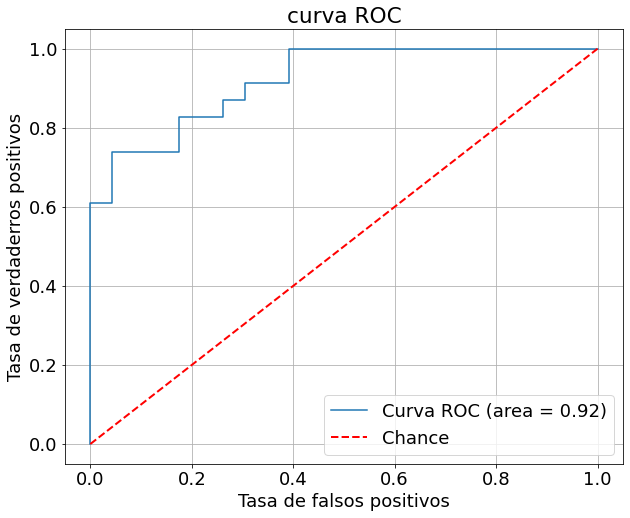

In [74]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 18})
plot_roc(fpr, tpr)

In [73]:
accuracy_score(y_pred_occ,y_occ)
print(proportion_confint(np.sum(np.equal(y_pred_occ,y_occ)),len(y_occ),method='jeffreys'))
cm = confusion_matrix(y_pred_occ,y_occ)


(0.6984867049748235, 0.9141815484067509)


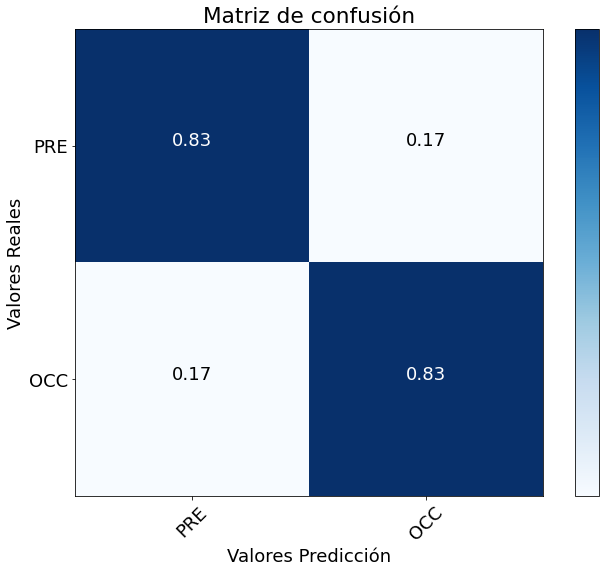

In [72]:

plot_confusion_matrix(cm, ["PRE", "OCC"],normalize=True)

## FRO

In [21]:
fro_post, subjects_list_fro_post =  get_all_data(['_scan_restpost'], ['ses-fro'], subjects, dirpath, parcel,schafer)


all_fro = pre_average + fro_post
subjects_fro = subjects_list_fro_pre + subjects_list_fro_post
y_fro = [0]*len(subjects_list_fro_pre) + [1]*len(subjects_list_fro_post)


cat_subjects = pd.get_dummies(subjects_fro)

subjects_id_fro = cat_subjects.values.argmax(1)

class_names = ['Pre', 'Fro']

X_fro = np.swapaxes(np.swapaxes(np.dstack(all_fro), 0,2),1,2)
y_fro = np.array(y_fro)

X_fro.shape

(46, 600, 376)

###  GRID SEARCH

In [33]:
base_model = hmm.GMMHMM(covariance_type="diag",init_params="cm", params="cm",n_iter=100)
model_hmm = hmm_helper.HMM_classifier(base_model)


pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D()),("model", model_hmm)])

parameters = {  'pca__n_components': [0.70, 0.8 ,0.85,0.9, 1],
                'model__hmm_model': [base_model],
                'model__n_components':[*range(8,12)],
                'model__n_mix': [*range(2,5)]
}

In [34]:
grid_search_m_fro = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy", verbose = 1,n_jobs=-1)

grid_search_m_fro.fit(X = X_fro, y = y_fro, groups = subjects_id_fro)

Fitting 23 folds for each of 60 candidates, totalling 1380 fits


GridSearchCV(cv=LeaveOneGroupOut(),
             estimator=Pipeline(steps=[('scaler', StandardScaler3D()),
                                       ('pca', PCA3D()),
                                       ('model',
                                        HMM_classifier(hmm_model=GMMHMM(init_params='cm',
                                                                        n_iter=100,
                                                                        params='cm')))]),
             n_jobs=-1,
             param_grid={'model__hmm_model': [GMMHMM(init_params='cm',
                                                     n_iter=100, params='cm')],
                         'model__n_components': [8, 9, 10, 11],
                         'model__n_mix': [2, 3, 4],
                         'pca__n_components': [0.7, 0.8, 0.85, 0.9, 1]},
             scoring='accuracy', verbose=1)

In [35]:
print('Best Score: %s' % grid_search_m_fro.best_score_)
print('Best Hyperparameters: %s' % grid_search_m_fro.best_params_)

Best Score: 0.8695652173913043
Best Hyperparameters: {'model__hmm_model': GMMHMM(init_params='cm', n_iter=100, params='cm'), 'model__n_components': 9, 'model__n_mix': 4, 'pca__n_components': 0.7}


In [36]:
base_model = hmm.GaussianHMM(n_components=states , covariance_type="full",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D()),("model", model_hmm)])

parameters = {  'pca__n_components': [0.70, 0.8 ,0.85,0.9, 0.95, 1],
                'model__hmm_model': [base_model],
                'model__n_components':[*range(8,17)]}

In [37]:
grid_search_g_fro = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy",n_jobs=-1)

grid_search_g_fro.fit(X = X_fro, y = y_fro, groups = subjects_id_fro)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

KeyboardInterrupt: 

In [ ]:
grid_search_g_fro.cv_results_

In [ ]:
print('Best Score: %s' % grid_search_g_fro.best_score_)
print('Best Hyperparameters: %s' % grid_search_g_fro.best_params_)

## BEST MODEL

In [87]:
states = 9
n_components=0.7
n_mix = 4

base_model = hmm.GMMHMM(covariance_type="diag",init_params="cm", params="cm",n_iter=100)
model_hmm = hmm_helper.HMM_classifier(base_model,n_components=states,n_mix=n_mix)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D(n_components=n_components_pca)),("model", model_hmm)])

cv = LeaveOneGroupOut()

scores_fro = cross_val_score(pipe, X_fro, y_fro, cv = cv, scoring='accuracy', groups = subjects_id_fro,n_jobs=-1)
y_score_fro = cross_val_predict(pipe,  X_fro, y_fro, cv = cv ,method='predict_proba', groups = subjects_id_fro,n_jobs=-1)
y_pred_fro = cross_val_predict(pipe,  X_fro, y_fro, cv = cv, groups = subjects_id_fro,n_jobs=-1)



In [88]:
scores_fro.mean()

0.8043478260869565

In [89]:
y_pred_fro

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1])

In [90]:
scores_fro

array([1. , 0.5, 1. , 1. , 0.5, 0.5, 0.5, 1. , 0.5, 1. , 0.5, 1. , 1. ,
       1. , 1. , 1. , 0.5, 1. , 1. , 1. , 0.5, 1. , 0.5])

In [91]:
accuracy_score(y_fro, y_pred_fro)

0.782608695652174

In [92]:
y_score_p = y_score_fro[:,1]-y_score_fro[:,0]
auc = metrics.roc_auc_score(y_fro, y_score_p)
auc

0.9243856332703214

In [93]:
error = proportion_confint(np.sum(np.equal(y_pred_fro,y_fro)),len(y_fro),method='jeffreys')
error

(0.6485572791678698, 0.8823845084607068)

In [94]:
fpr, tpr, thresh = metrics.roc_curve(y_fro, y_score_p)

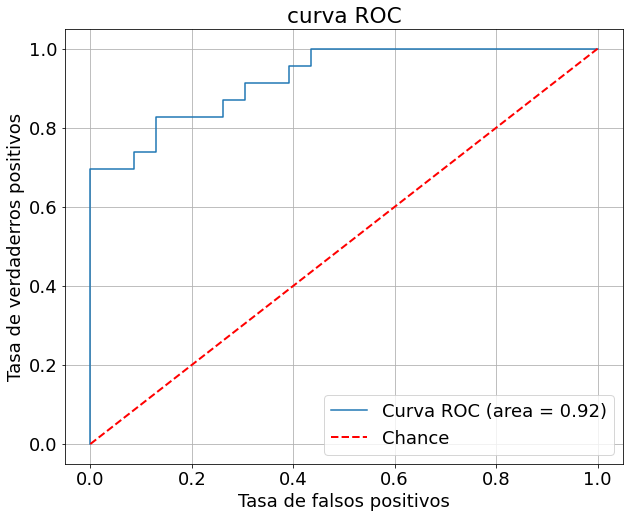

In [95]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 18})
plot_roc(fpr, tpr)

In [96]:
accuracy_score(y_pred_fro,y_fro)
print(proportion_confint(np.sum(np.equal(y_pred_fro,y_fro)),len(y_fro),method='jeffreys'))
cm = confusion_matrix(y_pred_fro,y_fro)

(0.6485572791678698, 0.8823845084607068)


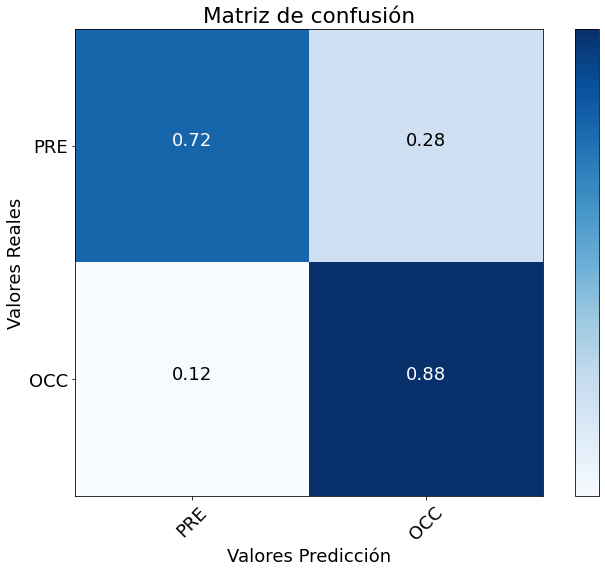

In [97]:
plot_confusion_matrix(cm, ["PRE", "OCC"],normalize=True)

## FRO VS CTR

In [54]:
diff_occ = list(np.array(occ_post)- np.array(pre_average))
diff_fro = list(np.array(fro_post)- np.array(pre_average))

diff_occ = occ_post
diff_fro = fro_post

subjects_diff = subjects_list_occ_post + subjects_list_fro_post
y_diff = [0]*len(subjects_list_occ_post) + [1]*len(subjects_list_fro_post)

all_diff = diff_occ + diff_fro
X_diff = np.swapaxes(np.swapaxes(np.dstack(all_diff), 0,2),1,2)
y_diff = np.array(y_diff)

In [55]:
X_diff.shape

(46, 600, 376)

In [56]:
base_model = hmm.GMMHMM(covariance_type="diag",init_params="cm", params="cm", random_state=42, n_iter=100)
model_hmm = hmm_helper.HMM_classifier(base_model)


pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D()),("model", model_hmm)])

parameters = {  'pca__n_components': [0.70, 0.8,0.9, 1],
                'model__hmm_model': [base_model],
                'model__n_components':[*range(8,15)],
                'model__n_mix': [*range(2,7)]
}

In [57]:
grid_search_fro_occ = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy", verbose = 3,n_jobs=-1)

grid_search_fro_occ.fit(X = X_diff, y = y_diff, groups = subjects_diff)

Fitting 23 folds for each of 140 candidates, totalling 3220 fits
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.1s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.5s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  14.4s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  20.1s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=1;,

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  16.5s[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  12.8s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  12.9s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  15.3s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  20.9s
[CV 14/23] END model__hmm_model=GMM

[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  18.0s[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.1s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.8s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  24.9s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  24.6s
[CV 4/23] END model__hmm_model=GMMHMM(in

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  17.5s[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  14.1s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.6s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  24.9s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  21.7s
[CV 2/23] END model__hmm_model=GMMHMM

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  10.8s[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  13.4s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  16.0s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  22.6s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  20.3s
[CV 22/23] END model__hmm_model=GM

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  16.0s[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  13.7s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  15.7s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  24.5s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  22.4s
[CV 1/23] END model__hmm_model=GMMHMM

[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  11.5s[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.4s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  17.1s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  25.6s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  14.0s
[CV 20/23] END model__hmm_model=GMM

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  12.3s[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.2s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.7s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  25.4s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  27.5s
[CV 8/23] END model__hmm_model=GMMHMM

[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  14.1s[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.4s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  16.1s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  24.8s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  27.8s
[CV 6/23] END model__hmm_model=GMMH

[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  19.1s[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.2s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.1s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  15.9s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  19.2s
[CV 15/23] END model__hmm_model=G

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  20.7s[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  12.9s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  15.6s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  16.0s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  21.0s
[CV 18/23] END model__hmm_model=G

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  20.3s[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.1s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  12.9s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  14.6s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  19.7s
[CV 12/23] END model__hmm_model=G

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  19.9s[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  13.4s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.6s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  26.1s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  27.2s
[CV 10/23] END model__hmm_model=GMM

[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  19.7s[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.6s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.2s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  24.5s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  27.7s
[CV 5/23] END model__hmm_model=GMMH

[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  21.4s[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.2s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  18.2s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=1.000 total time=  23.3s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  12.9s
[CV 19/23] END model__hmm_model=GM

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.4s[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.7s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  15.6s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  24.6s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  17.5s
[CV 21/23] END model__hmm_model=

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  20.4s[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  13.1s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.4s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  25.9s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=1;, score=0.500 total time=  27.7s
[CV 9/23] END model__hmm_model=GMMHM

[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  34.3s[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.4s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.8s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  25.6s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=1;, score=1.000 total time=  27.1s
[CV 7/23] END model__hmm_model=GMMHMM

[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  36.1s[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.4s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  15.7s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  15.8s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  20.6s
[CV 17/23] END model__hmm_model=GM

[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  38.0s[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  13.3s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.6s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  23.9s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=8, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  19.5s
[CV 23/23] END model__hmm_model=GMM

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  35.2s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  12.0s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  14.0s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  21.1s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  36.9s
[CV 14/23] END model__hmm_model

[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=4, pca__n_components=0.9;, score=0.500 total time=  33.4s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  13.2s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  20.5s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  35.9s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  17.4s
[CV 3/23] END model__hmm_model=G

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  21.0s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  12.7s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  20.8s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  34.7s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=1.000 total time=  16.4s
[CV 5/23] END model__hmm_model=GMMH

[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.7;, score=0.500 total time=  12.8s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  15.6s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  13.2s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  22.0s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  34.8s
[CV 10/23] END model__hmm_model=

[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.7;, score=0.500 total time=  12.8s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  15.1s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  19.9s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  35.3s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=   5.8s
[CV 17/23] END model__hmm_model

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  19.5s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  22.2s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  32.2s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  16.9s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  12.0s
[CV 10/23] END model__hmm_model

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  19.9s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  38.6s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  18.3s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  16.0s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  12.0s
[CV 17/23] END model__hmm_model=GM

[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  22.4s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  34.9s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  16.8s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  13.6s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  11.8s
[CV 13/23] END model__hmm_model=GM

[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.8;, score=1.000 total time=  21.6s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  13.1s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  13.1s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  19.7s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  36.4s
[CV 6/23] END model__hmm_model=G

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  37.2s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  34.5s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  30.3s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=   9.8s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.0s
[CV 1/23] END model__hmm_model

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  36.8s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  34.7s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  17.4s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  11.7s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  14.9s
[CV 2/23] END model__hmm_model=

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  18.0s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  19.1s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  38.7s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  29.4s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  11.0s
[CV 8/23] END model__hmm_model=G

[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  21.3s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  38.2s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  16.6s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  10.8s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.5s
[CV 23/23] END model__hmm_model=GM

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  21.2s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  17.6s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  16.5s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  11.9s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  15.1s
[CV 12/23] END model__hmm_model=GMM

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  20.8s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  33.4s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  17.2s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  12.4s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.8s
[CV 11/23] END model__hmm_model

[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  13.9s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=1.000 total time=  14.6s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  12.3s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  15.3s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  24.2s
[CV 4/23] END model__hmm_model

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  22.1s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  30.5s
[CV 9/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  10.6s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  15.5s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  24.4s
[CV 22/23] END model__hmm_model

[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  23.1s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  16.5s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=9, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  16.8s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.1s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=10, model__n_mix=2, pca__n_components=0.9;, score=0.500 total time=  25.0s
[CV 23/23] END model__hmm_model=GM

[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  42.8s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=4, pca__n_components=1;, score=0.500 total time=   6.1s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=4, pca__n_components=1;, score=1.000 total time=  18.4s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  13.0s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  20.5s
[CV 7/23] END model__hmm_model

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=3, pca__n_components=0.9;, score=0.500 total time=  30.9s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.7;, score=0.500 total time=  12.1s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.7;, score=0.500 total time=  14.4s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  21.3s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.9;, score=1.000 total time=  38.2s
[CV 12/23] END model__hmm_

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=4, pca__n_components=0.8;, score=0.500 total time=  19.8s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  37.5s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=1.000 total time=  17.2s
[CV 7/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  12.6s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  14.4s
[CV 17/23] END model__hmm_mod

[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=4, pca__n_components=0.8;, score=0.500 total time=  20.3s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.7;, score=1.000 total time=  15.2s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  21.9s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  37.0s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  22.0s
[CV 11/23] END model__hmm_m

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=4, pca__n_components=0.8;, score=0.500 total time=  20.2s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.9;, score=0.000 total time=  37.3s
[CV 5/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  22.6s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  12.0s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  15.1s
[CV 16/23] END model__hmm_mod

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=4, pca__n_components=0.8;, score=0.500 total time=  21.1s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  21.1s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  36.3s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  28.8s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  13.1s
[CV 20/23] END model__hmm_mo

[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=4, pca__n_components=0.8;, score=0.500 total time=  21.1s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  23.2s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  34.3s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  20.2s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  13.0s
[CV 9/23] END model__hmm_mo

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=4, pca__n_components=0.8;, score=0.500 total time=  22.1s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  13.5s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  15.4s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  23.7s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  40.9s
[CV 12/23] END model__hmm_

[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  28.4s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  22.1s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  12.8s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.2s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  41.6s
[CV 22/23] END model__hmm_model=

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  25.8s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  30.4s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  20.9s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.6s
[CV 4/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  39.3s
[CV 23/23] END model__hmm_model=

[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=4, pca__n_components=1;, score=1.000 total time=  23.1s
[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  13.0s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  14.1s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  24.1s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  41.9s
[CV 14/23] END model__hmm_mo

[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  28.3s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  36.3s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  21.7s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  14.0s
[CV 11/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.9s
[CV 8/23] END model__hmm_mode

[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  26.8s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  21.9s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  34.7s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  22.4s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=1.000 total time=  14.2s
[CV 12/23] END model__hmm_mod

[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=4, pca__n_components=1;, score=0.500 total time=  22.1s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  12.9s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  15.0s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  23.7s
[CV 12/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  42.1s
[CV 11/23] END model__hmm_mo

[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=5, pca__n_components=0.7;, score=0.500 total time=  14.4s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.0s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  23.3s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  39.5s
[CV 15/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  22.0s
[CV 15/23] END model__hmm_mo

[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=5, pca__n_components=0.7;, score=0.500 total time=  14.4s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.2s
[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  23.5s
[CV 20/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  38.5s
[CV 17/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  19.7s
[CV 12/23] END model__hmm_mo

[CV 8/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=5, pca__n_components=0.8;, score=0.500 total time=  22.2s
[CV 14/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  41.8s
[CV 13/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  21.8s
[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=12, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  10.6s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=12, model__n_mix=2, pca__n_components=0.8;, score=0.500 total time=  16.6s
[CV 23/23] END model__hmm_mod

[CV 23/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=5, pca__n_components=0.9;, score=0.500 total time=  31.0s
[CV 2/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.9s
[CV 22/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=1.000 total time=  23.1s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  38.9s
[CV 16/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  21.6s
[CV 14/23] END model__hmm_mo

[CV 10/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=6, pca__n_components=0.7;, score=0.500 total time=  13.5s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  22.8s
[CV 19/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=1;, score=0.500 total time=  20.5s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=12, model__n_mix=2, pca__n_components=0.7;, score=1.000 total time=  13.0s
[CV 18/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=12, model__n_mix=2, pca__n_components=0.8;, score=1.000 total time=  16.7s
[CV 15/23] END model__hmm_mode

[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=13, model__n_mix=5, pca__n_components=1;, score=0.500 total time=  26.3s
[CV 6/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.8;, score=0.500 total time=  21.8s
[CV 3/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=0.500 total time=  39.8s
[CV 21/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=11, model__n_mix=6, pca__n_components=0.9;, score=1.000 total time=  30.4s
[CV 1/23] END model__hmm_model=GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), model__n_components=12, model__n_mix=2, pca__n_components=0.7;, score=0.500 total time=  11.3s
[CV 16/23] END model__hmm_mode

GridSearchCV(cv=LeaveOneGroupOut(),
             estimator=Pipeline(steps=[('scaler', StandardScaler3D()),
                                       ('pca', PCA3D()),
                                       ('model',
                                        HMM_classifier(hmm_model=GMMHMM(init_params='cm',
                                                                        n_iter=100,
                                                                        params='cm',
                                                                        random_state=42)))]),
             n_jobs=-1,
             param_grid={'model__hmm_model': [GMMHMM(init_params='cm',
                                                     n_iter=100, params='cm',
                                                     random_state=42)],
                         'model__n_components': [8, 9, 10, 11, 12, 13, 14],
                         'model__n_mix': [2, 3, 4, 5, 6],
                         'pca__n_components': [0.7, 0.8

In [58]:
print('Best Score: %s' % grid_search_fro_occ.best_score_)
print('Best Hyperparameters: %s' % grid_search_fro_occ.best_params_)

Best Score: 0.6304347826086957
Best Hyperparameters: {'model__hmm_model': GMMHMM(init_params='cm', n_iter=100, params='cm', random_state=42), 'model__n_components': 8, 'model__n_mix': 5, 'pca__n_components': 0.8}


In [59]:
grid_search_fro_occ.cv_results_

{'mean_fit_time': array([13.24255502, 16.07185415, 22.77006544, 22.54463942, 10.10444467,
        18.578604  , 29.16511677, 15.47774892, 10.76931989, 17.01120663,
        27.48256019, 14.23577403, 11.41056807, 18.1984188 , 30.10549898,
        13.34654442, 12.34755678, 19.22830883, 32.71477261, 13.53581865,
        11.00616577, 14.9614251 , 22.61796964, 24.699687  , 10.55262948,
        16.0006624 , 26.05293086, 17.60326233, 10.72215083, 17.51718638,
        29.65322937, 15.99427607, 11.97773636, 19.00033494, 31.83287126,
        15.74852822, 12.44850003, 20.32995478, 34.82798526, 16.01030464,
        11.44458611, 15.7695213 , 23.64192943, 24.01856782, 11.23617691,
        16.72883252, 26.9979771 , 18.62115021, 11.60083714, 18.03805291,
        30.31025573, 17.50336734, 12.36772733, 19.6712159 , 33.54964106,
        17.89279583, 12.92568017, 21.34434177, 36.6414249 , 17.57871589,
        11.88868569, 16.53398865, 25.11534268, 25.93222484, 11.61928621,
        17.59469518, 28.89869731, 

In [108]:
base_model = hmm.GaussianHMM(covariance_type="full",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D()),("model", model_hmm)])

parameters = {  'pca__n_components': [0.70, 0.8 ,0.9, 1],
                'model__hmm_model': [base_model],
                'model__n_components':[*range(8,12)]
             }

In [109]:
grid_search_g_fro_occ = GridSearchCV(pipe, parameters, cv = LeaveOneGroupOut(), scoring="accuracy",n_jobs=-1)

grid_search_g_fro_occ.fit(X = X_diff, y = y_diff, groups = subjects_diff)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

GridSearchCV(cv=LeaveOneGroupOut(),
             estimator=Pipeline(steps=[('scaler', StandardScaler3D()),
                                       ('pca', PCA3D()),
                                       ('model',
                                        HMM_classifier(hmm_model=GaussianHMM(covariance_type='full',
                                                                             n_iter=100,
                                                                             random_state=42)))]),
             n_jobs=-1,
             param_grid={'model__hmm_model': [GaussianHMM(covariance_type='full',
                                                          n_iter=100,
                                                          random_state=42)],
                         'model__n_components': [8, 9, 10, 11],
                         'pca__n_components': [0.7, 0.8, 0.9, 1]},
             scoring='accuracy')

In [110]:
print('Best Score: %s' % grid_search_g_fro_occ.best_score_)
print('Best Hyperparameters: %s' % grid_search_g_fro_occ.best_params_)

Best Score: 0.6521739130434783
Best Hyperparameters: {'model__hmm_model': GaussianHMM(covariance_type='full', n_iter=100, random_state=42), 'model__n_components': 10, 'pca__n_components': 1}


### BEST MODEL

In [122]:
states = 10
n_components_pca=1
n_mix = 5

base_model = hmm.GaussianHMM(covariance_type="full",n_iter=100, random_state=42)
model_hmm = hmm_helper.HMM_classifier(base_model,n_components=states)

pipe = Pipeline(steps=[("scaler", series_utils.StandardScaler3D()), ('pca', series_utils.PCA3D(n_components=n_components_pca)),("model", model_hmm)])

cv = LeaveOneGroupOut()

scores_fro_occ = cross_val_score(pipe, X_diff, y_diff, cv = cv, scoring='accuracy', groups = subjects_id_fro,n_jobs=-1)
y_score_fro_occ = cross_val_predict(pipe,  X_diff, y_diff, cv = cv ,method='predict_proba', groups = subjects_id_fro,n_jobs=-1)
y_pred_fro_occ = cross_val_predict(pipe,  X_diff, y_diff, cv = cv, groups = subjects_id_fro,n_jobs=-1)



Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_param

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


In [123]:
scores_fro_occ.mean()

0.6521739130434783

In [124]:
y_score_p = y_score_fro_occ[:,1]-y_score_fro_occ[:,0]
auc = metrics.roc_auc_score(y_diff, y_score_p)
auc

0.6691871455576559

In [125]:
y_pred_fro_occ

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0])

In [126]:
accuracy_score(y_diff, y_pred_fro_occ)

0.6521739130434783

In [127]:
error = proportion_confint(np.sum(np.equal(y_pred_fro_occ,y_diff)),len(y_diff),method='jeffreys')
error

(0.5086316459975526, 0.7772325243864426)

In [128]:
fpr, tpr, thresh = metrics.roc_curve(y_diff, y_score_p)

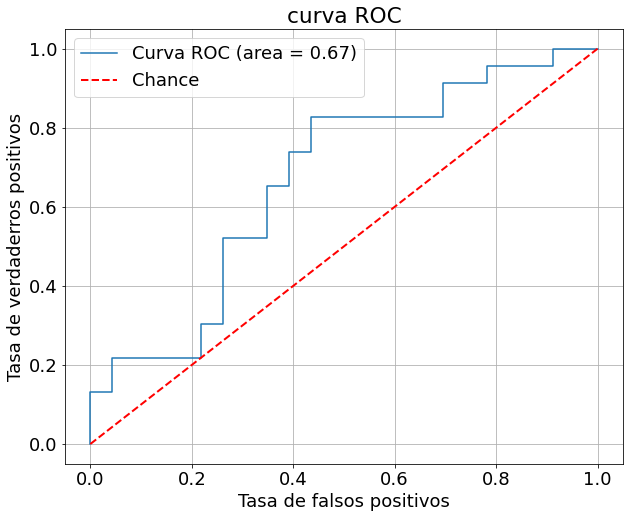

In [129]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 18})
plot_roc(fpr, tpr)

In [130]:
accuracy_score(y_pred_fro_occ,y_diff)
print(proportion_confint(np.sum(np.equal(y_pred_fro_occ,y_diff)),len(y_diff),method='jeffreys'))
cm = confusion_matrix(y_pred_fro_occ, y_diff)

(0.5086316459975526, 0.7772325243864426)


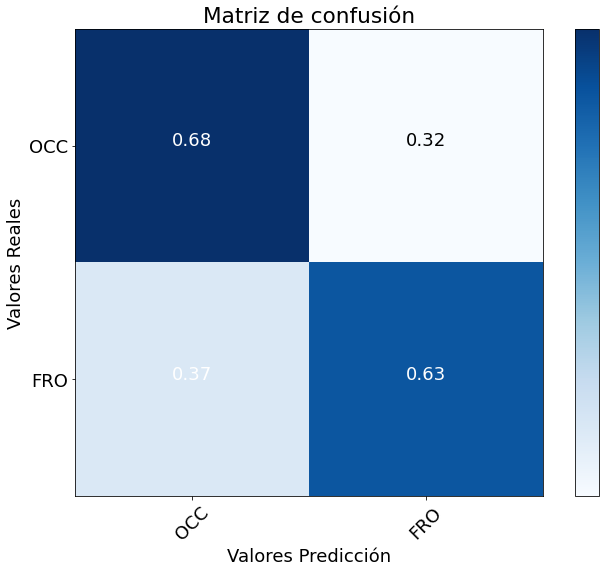

In [131]:

plot_confusion_matrix(cm, ["OCC", "FRO"],normalize=True)

In [72]:
cm

array([[ 7,  1],
       [16, 22]])

In [48]:
y_pred_fro_occ

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [49]:
y_diff

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])